In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import random

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm
from PIL import Image

In [2]:
import cv2

In [3]:
# Creating some helper functions
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [4]:
class SiameseNetworkDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.transform = transform

    def __getitem__(self, index):
        img0_tuple = random.choice(self.image_folder.imgs)
        should_get_same_class = random.randint(0, 1)
        if should_get_same_class:
            while True:
                img1_tuple = random.choice(self.image_folder.imgs)
                if img0_tuple[1] == img1_tuple[1] and img0_tuple[0] != img1_tuple[0]:
                    break
        else:
            while True:
                img1_tuple = random.choice(self.image_folder.imgs)
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0]).convert("RGB")
        img1 = Image.open(img1_tuple[0]).convert("RGB")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        # Ensure the images have 3 channels
        #if img0.shape[0] != 3 or img1.shape[0] != 3:
            #raise ValueError("Images should have 3 channels (RGB).")
        return (img0, img0_tuple[0], img0_tuple[1]), (img1, img1_tuple[0], img1_tuple[1]), torch.from_numpy(
        np.array([int(img0_tuple[1] != img1_tuple[1])], dtype=np.float32))

    def __len__(self):
        return len(self.image_folder)


In [5]:

class SiameseNetwork(nn.Module):
    def __init__(self, base_model):
        super(SiameseNetwork, self).__init__()
        self.base_model = base_model

    def forward(self, img1, img2):
        output1 = self.base_model(img1)
        output2 = self.base_model(img2)
        return output1, output2


In [6]:
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11,stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU(inplace=True)
        )

        # Compute the size of the output from the convolutional layers
        # using a dummy input
        dummy_input = torch.zeros(1, 1, 600, 300)
        dummy_output = self.cnn1(dummy_input)
        cnn_output_size = dummy_output.view(-1).size(0)

        # Setting up the Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(cnn_output_size, 1024),
            nn.ReLU(inplace=True),
            
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256,2)
        )
        
    def forward_once(self, x):
        # This function will be called for both images
        # Its output is used to determine the similiarity
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

In [7]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidean distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

In [8]:
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor

def load_detectron_model(config_file, model_weights):
    cfg = get_cfg()
    cfg.merge_from_file(config_file)
    cfg.MODEL.WEIGHTS = model_weights
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
    cfg.MODEL.DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    predictor = DefaultPredictor(cfg)
    return predictor


In [9]:
config_file = "model_configs/config.yaml"
weights_file = "pytorch_weights/model_final.pth"

predictor = load_detectron_model(config_file, weights_file)


Loading config model_configs/config.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


In [10]:
class ApplyMask:
    def __init__(self, predictor):
        self.predictor = predictor

    def __call__(self, img):
        if not isinstance(img, Image.Image):
            img = Image.fromarray(img)

        img_np = np.array(img)
        outputs = self.predictor(img_np)
        if len(outputs['instances']) > 0:
            mask = outputs['instances'].pred_masks[0].cpu().numpy()
            masked_img = img_np * mask[..., np.newaxis]

            # Get the bounding box coordinates
            bbox = outputs['instances'].pred_boxes.tensor[0].cpu().numpy()
            x1, y1, x2, y2 = bbox.astype(int)

            # Crop the image using the bounding box coordinates
            cropped_img = masked_img[y1:y2, x1:x2]

            img_cropped = Image.fromarray(cropped_img)
            return img_cropped
        else:
            return img

In [11]:
apply_mask = ApplyMask(predictor)

In [12]:
import cv2
def apply_grayscale_and_filter(img):
    img = np.array(img)
    result = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    result = cv2.medianBlur(result, 1)
    result = cv2.adaptiveThreshold(result, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 101, 1)
    #result = cv2.adaptiveThreshold(result, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 13, 5)
    result = Image.fromarray(result, mode="L")
    return result

In [13]:
import cv2
def apply_grayscale(img):
    img = np.array(img)
    result = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    result = Image.fromarray(result, mode="L")
    return result

In [14]:
root_folder = '.'

train_transform = transforms.Compose([apply_mask,
                                      apply_grayscale,
                                      transforms.Resize((600, 300)),
                                      transforms.ToTensor()
                                      ])
val_transform = transforms.Compose([apply_mask,
                                      apply_grayscale,
                                      transforms.Resize((600, 300)),
                                      transforms.ToTensor()
                                      ])
test_transform = transforms.Compose([apply_mask,
                                     apply_grayscale,
                                     transforms.Resize((600, 300)),
                                     transforms.ToTensor()
                                     ])

train_dataset = datasets.ImageFolder('siamese_data/train')
val_dataset = datasets.ImageFolder('siamese_data/val')
test_dataset = datasets.ImageFolder('siamese_data/test')

In [15]:
siamese_train_dataset = SiameseNetworkDataset(train_dataset, transform=train_transform)
siamese_val_dataset = SiameseNetworkDataset(val_dataset, transform=val_transform)
siamese_test_dataset = SiameseNetworkDataset(test_dataset, transform=test_transform)

Dataset: Training Set
Number of samples: 653
Number of classes: 175


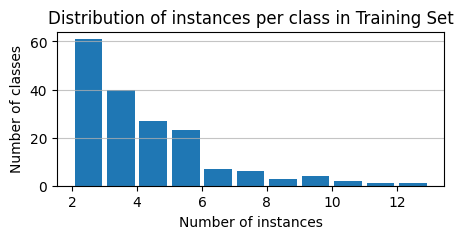

Dataset: Validation Set
Number of samples: 137
Number of classes: 35


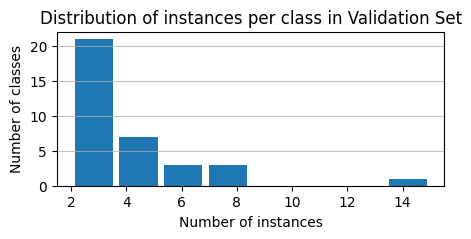

Dataset: Test Set
Number of samples: 137
Number of classes: 37


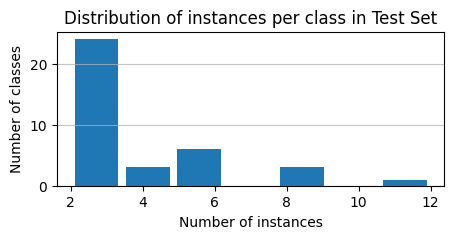

In [16]:
import matplotlib.pyplot as plt

def display_dataset_info(dataset, name):
    print(f"Dataset: {name}")
    print(f"Number of samples: {len(dataset)}")
    print(f"Number of classes: {len(dataset.image_folder.classes)}")
    
    # Count the number of samples per class
    class_counts = {class_name: 0 for class_name in dataset.image_folder.classes}
    for _, class_index in dataset.image_folder.imgs:
        class_name = dataset.image_folder.classes[class_index]
        class_counts[class_name] += 1
    
    # Plot the distribution of instances per class
    plt.figure(figsize=(5, 2))
    plt.hist(class_counts.values(), bins='auto', rwidth=0.85)
    plt.xlabel("Number of instances")
    plt.ylabel("Number of classes")
    plt.title(f"Distribution of instances per class in {name}")
    plt.grid(axis='y', alpha=0.75)
    plt.show()

# Display information about the datasets
display_dataset_info(siamese_train_dataset, "Training Set")
display_dataset_info(siamese_val_dataset, "Validation Set")
display_dataset_info(siamese_test_dataset, "Test Set")


Dataset: Training Set
Number of samples: 653
Number of classes: 175
Dataset: Validation Set
Number of samples: 137
Number of classes: 35
Dataset: Test Set
Number of samples: 137
Number of classes: 37


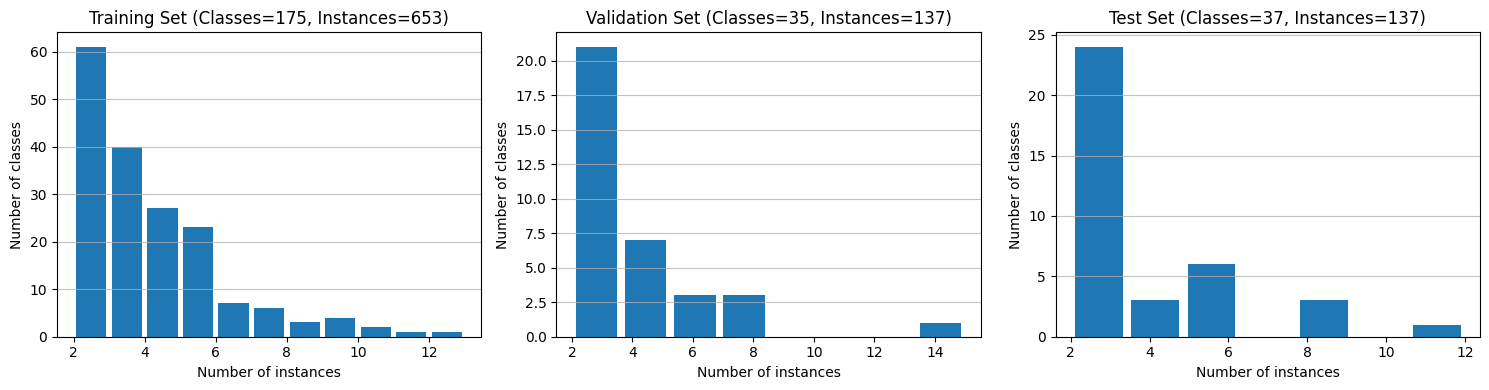

In [17]:
import matplotlib.pyplot as plt

def display_dataset_info(datasets, names):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    for dataset, name, ax in zip(datasets, names, axes):
        print(f"Dataset: {name}")
        print(f"Number of samples: {len(dataset)}")
        print(f"Number of classes: {len(dataset.image_folder.classes)}")

        # Count the number of samples per class
        class_counts = {class_name: 0 for class_name in dataset.image_folder.classes}
        for _, class_index in dataset.image_folder.imgs:
            class_name = dataset.image_folder.classes[class_index]
            class_counts[class_name] += 1

        # Plot the distribution of instances per class
        ax.hist(class_counts.values(), bins='auto', rwidth=0.85)
        ax.set_xlabel("Number of instances")
        ax.set_ylabel("Number of classes")
        ax.set_title(f"{name} (Classes={len(dataset.image_folder.classes)}, Instances={len(dataset)})")
        ax.grid(axis='y', alpha=0.75)

    plt.tight_layout()
    plt.show()

# Display information about the datasets
display_dataset_info(
    [siamese_train_dataset, siamese_val_dataset, siamese_test_dataset],
    ["Training Set", "Validation Set", "Test Set"]
)

/home/nicolaiep/.local/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


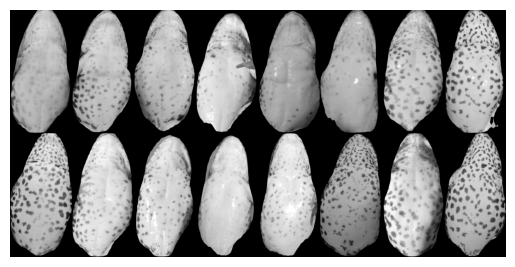

tensor([[1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.]])


In [18]:
# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(siamese_train_dataset,
                            shuffle=True,
                            batch_size=8)

# Extract one batch
(img0, img0_filename, img0_id), (img1, img1_filename, img1_id), label = next(iter(vis_dataloader))

# Example batch is a list containing 2x8 images, indexes 0 and 1, and also the label
# If the label is 1, it means that it is not the same person, label is 0, same person in both images
concatenated_images = torch.cat((img0, img1), 0)

imshow(torchvision.utils.make_grid(concatenated_images))
print(label)

In [19]:
# Create DataLoaders for the Siamese datasets
siamese_train_loader = DataLoader(siamese_train_dataset, batch_size=32, shuffle=True)
siamese_val_loader = DataLoader(siamese_val_dataset, batch_size=32, shuffle=True)
siamese_test_loader = DataLoader(siamese_test_dataset, batch_size=32, shuffle=False)

In [22]:
"""
from torchvision.models import resnet34

# Define the Siamese network architecture
base_model = resnet34(pretrained=True)
base_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Change in_channels from 3 to 1
num_features = base_model.fc.in_features
base_model.fc = nn.Identity()
siamese_network = SiameseNetwork(base_model)

# Set device to GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
siamese_network = siamese_network.to(device)

# Define the loss function and optimizer
criterion = ContrastiveLoss()
optimizer = optim.Adam(siamese_network.parameters(), lr=0.001)
"""

In [26]:
siamese_network = SiameseNetwork()

# Set device to GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
siamese_network = siamese_network.to(device)

# Define the loss function and optimizer
criterion = ContrastiveLoss()
optimizer = optim.Adam(siamese_network.parameters(), lr = 0.0005 )

In [25]:
data_iter = iter(siamese_train_loader)
(img1, img2, label) = next(data_iter)

# Print the data types
print(f"Type of img1: {type(img1)}")
print(f"Type of img2: {type(img2)}")
print(f"Type of label: {type(label)}")

# Print the shapes of the tensors
print(f"Shape of img1: {img1.shape}")
print(f"Shape of img2: {img2.shape}")
print(f"Shape of label: {label.shape}")

Type of img1: <class 'torch.Tensor'>
Type of img2: <class 'torch.Tensor'>
Type of label: <class 'torch.Tensor'>
Shape of img1: torch.Size([1, 1, 200, 100])
Shape of img2: torch.Size([1, 1, 200, 100])
Shape of label: torch.Size([1, 1])


In [16]:
from tqdm.notebook import tqdm

def train_siamese_network(train_loader, model, criterion, optimizer, device, num_epochs=10):
    model.train()
    for epoch in tqdm(range(num_epochs)):
        running_loss = 0.0
        for img1, img2, label in tqdm(train_loader):
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            optimizer.zero_grad()

            output1, output2 = model(img1, img2)
            loss = criterion(output1, output2, label)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        #print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')
        with open('siamese_training.log', 'a') as f:
            f.write(f"Finished epoch {epoch}. Running loss: {running_loss}\n")


In [37]:
# Train the Siamese network
num_epochs = 25
train_siamese_network(siamese_train_loader, siamese_network, criterion, optimizer, device, num_epochs)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [27]:
import datetime
from tqdm.notebook import tqdm

train_loss_history = []
val_loss_history = []
iteration_number = 0

num_epochs = 10

# Iterate through the epochs
for epoch in tqdm(range(num_epochs)):

    # Training phase
    siamese_network.train()  # Set the model to training mode
    train_loss = 0
    train_iterations = 0
    for (img0, img0_filename, img0_id), (img1, img1_filename, img1_id), label in tqdm(siamese_train_loader, leave=False, desc="Training"):
        
        # Send the images and labels to CUDA
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        output1, output2 = siamese_network(img0, img1)

        # Pass the outputs of the networks and label into the loss function
        loss_contrastive = criterion(output1, output2, label)

        # Calculate the backpropagation
        loss_contrastive.backward()

        # Optimize
        optimizer.step()

        train_loss += loss_contrastive.item()
        train_iterations += 1
    
    train_loss /= train_iterations  # Calculate average training loss
    train_loss_history.append(train_loss)  # Store the training loss
    
    # Validation phase
    siamese_network.eval()  # Set the model to evaluation mode
    val_loss = 0
    val_iterations = 0
    with torch.no_grad():
        for (img0, img0_filename, img0_id), (img1, img1_filename, img1_id), label in tqdm(siamese_val_loader, leave=False, desc="Validation"):
            img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
            output1, output2 = siamese_network(img0, img1)
            loss_contrastive = criterion(output1, output2, label)
            val_loss += loss_contrastive.item()
            val_iterations += 1

    val_loss /= val_iterations  # Calculate average validation loss
    val_loss_history.append(val_loss)  # Store the validation loss

    with open('new_siamese_training.log', 'a') as f:
        timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        f.write(f"Finished epoch {epoch}. Training loss: {train_loss:.4f}, Validation loss: {val_loss:.4f}. Timestamp: {timestamp}\n")

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

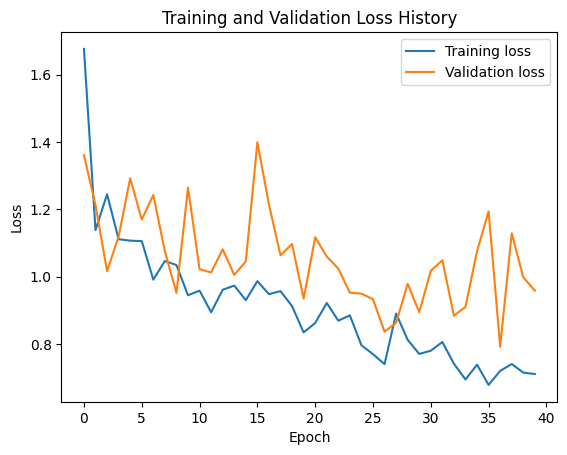

In [27]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Plot training loss history
ax.plot(train_loss_history, label='Training loss')

# Plot validation loss history
ax.plot(val_loss_history, label='Validation loss')

# Set the labels and title of the plot
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training and Validation Loss History')
ax.legend()

# Display the plot
plt.show()

# Find a good thresholding value

In [28]:
similarity_scores = []
true_labels = []

# Calculate similarity scores for all pairs in the validation set
for (img0, _, _), (img1, _, _), label in tqdm(siamese_val_loader):
    img0, img1 = img0.to(device), img1.to(device)
    output1, output2 = siamese_network(img0, img1)
    euclidean_distance = F.pairwise_distance(output1, output2)
    similarity_scores.extend(euclidean_distance.cpu().detach().numpy())
    true_labels.extend(label.numpy())

similarity_scores = np.array(similarity_scores)
true_labels = np.array(true_labels)

  0%|          | 0/5 [00:00<?, ?it/s]

In [29]:
from sklearn.metrics import f1_score, accuracy_score, precision_score
similarity_scores

# Search for the optimal threshold
print("max:", np.max(similarity_scores))
thresholds = np.linspace(0, np.max(similarity_scores), num=100)
best_threshold = thresholds[0]
best_metric = 0

for threshold in tqdm(thresholds):
    predicted_labels = (similarity_scores < threshold).astype(int)
    metric = accuracy_score(true_labels, predicted_labels)  # You can use accuracy_score or other metrics

    if metric > best_metric:
        best_metric = metric
        best_threshold = threshold

print(best_threshold)

max: 3.689433


  0%|          | 0/100 [00:00<?, ?it/s]

1.7142820454607106


In [45]:
from sklearn.metrics import f1_score, accuracy_score

def find_optimal_threshold(siamese_network, validation_loader):
    similarity_scores = []
    true_labels = []

    # Calculate similarity scores for all pairs in the validation set
    for (img0, _, _), (img1, _, _), label in tqdm(validation_loader):
        img0, img1 = img0.to(device), img1.to(device)
        output1, output2 = siamese_network(img0, img1)
        euclidean_distance = F.pairwise_distance(output1, output2)
        similarity_scores.extend(euclidean_distance.cpu().detach().numpy())
        true_labels.extend(label.numpy())

    similarity_scores = np.array(similarity_scores)
    true_labels = np.array(true_labels)

    # Search for the optimal threshold
    print("max:", np.max(similarity_scores))
    thresholds = np.linspace(0, np.max(similarity_scores), num=100)
    best_threshold = thresholds[0]
    best_metric = 0

    for threshold in tqdm(thresholds):
        predicted_labels = (similarity_scores < threshold).astype(int)
        metric = accuracy_score(true_labels, predicted_labels)  # You can use accuracy_score or other metrics

        if metric > best_metric:
            best_metric = metric
            best_threshold = threshold

    return best_threshold

optimal_threshold = find_optimal_threshold(siamese_network, siamese_val_loader)
print(optimal_threshold)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0.0


In [30]:
# Save the model's state_dict and other metadata
def save_checkpoint(model, optimizer, epoch, best_threshold, train_loss_history, val_loss_history, filepath):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_threshold': best_threshold,
        'train_loss_history': train_loss_history,
        'val_loss_history': val_loss_history
    }
    torch.save(checkpoint, filepath)

In [31]:
import datetime
# Get the current timestamp as a string
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

epoch = 40
# Save the current model with a unique timestamp in the filename
save_checkpoint(siamese_network, optimizer, epoch, best_threshold, train_loss_history, val_loss_history, f'siamese_models/custom_network/custom_epoch_{epoch}_checkpoint_{timestamp}.pth')


In [25]:
def load_checkpoint(filepath, device=None):
    checkpoint = torch.load(filepath)
    model = SiameseNetwork()
    if device is not None:
        model.to(device)  # move model to device before creating optimizer
    model.load_state_dict(checkpoint['model_state_dict'])
    
    optimizer = torch.optim.Adam(model.parameters())
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    epoch = checkpoint['epoch']
    best_threshold = checkpoint['best_threshold']
    
    train_loss_history = checkpoint['train_loss_history']
    val_loss_history = checkpoint['val_loss_history']
    
    return model, optimizer, epoch, best_threshold, train_loss_history, val_loss_history


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
siamese_network, optimizer, start_epoch, best_threshold, train_loss_history, val_loss_history = load_checkpoint('siamese_models/custom_network/custom_checkpoint_2023-05-11_20-06-54.pth', device)


In [52]:
from torchvision.models import resnet34

# Define the Siamese network architecture
base_model = resnet34(pretrained=True)
base_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Change in_channels from 3 to 1
num_features = base_model.fc.in_features
base_model.fc = nn.Identity()

def load_checkpoint(filepath, base_model):
    checkpoint = torch.load(filepath)
    model = SiameseNetwork(base_model)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    optimizer = torch.optim.Adam(model.parameters())
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    epoch = checkpoint['epoch']
    best_threshold = checkpoint['best_threshold']
    
    return model, optimizer, epoch, best_threshold

# Load the model from a checkpoint
siamese_network, optimizer, start_epoch, best_threshold = load_checkpoint('siamese_models/res34/res34_checkpoint_2023-05-10_16-44-18.pth', base_model)

# If you want to continue training from where you left off, you can start from 'start_epoch'
# Make sure to move the model to GPU if available
if torch.cuda.is_available():
    siamese_network = siamese_network.cuda()


In [ ]:
import datetime
from tqdm.notebook import tqdm


num_epochs = 40
criterion = ContrastiveLoss()

# Iterate through the epochs
for epoch in tqdm(range(start_epoch, num_epochs)):

    # Training phase
    siamese_network.train()  # Set the model to training mode
    train_loss = 0
    train_iterations = 0
    for (img0, img0_filename, img0_id), (img1, img1_filename, img1_id), label in tqdm(siamese_train_loader, leave=False, desc="Training"):
        
        # Send the images and labels to CUDA
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        output1, output2 = siamese_network(img0, img1)

        # Pass the outputs of the networks and label into the loss function
        loss_contrastive = criterion(output1, output2, label)

        # Calculate the backpropagation
        loss_contrastive.backward()

        # Optimize
        optimizer.step()

        train_loss += loss_contrastive.item()
        train_iterations += 1
    
    train_loss /= train_iterations  # Calculate average training loss
    train_loss_history.append(train_loss)  # Store the training loss
    
    # Validation phase
    siamese_network.eval()  # Set the model to evaluation mode
    val_loss = 0
    val_iterations = 0
    with torch.no_grad():
        for (img0, img0_filename, img0_id), (img1, img1_filename, img1_id), label in tqdm(siamese_val_loader, leave=False, desc="Validation"):
            img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
            output1, output2 = siamese_network(img0, img1)
            loss_contrastive = criterion(output1, output2, label)
            val_loss += loss_contrastive.item()
            val_iterations += 1

    val_loss /= val_iterations  # Calculate average validation loss
    val_loss_history.append(val_loss)  # Store the validation loss

    with open('new_siamese_training.log', 'a') as f:
        timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        f.write(f"Finished epoch {epoch}. Training loss: {train_loss:.4f}, Validation loss: {val_loss:.4f}. Timestamp: {timestamp}\n")

  0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/21 [00:00<?, ?it/s]

# Testing

In [28]:
def test_model(siamese_network, test_loader, threshold):
    siamese_network.eval()  # Set the network to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for (img0, img0_filename, img0_id), (img1, img1_filename, img1_id), label in tqdm(test_loader):
            # Send the images and labels to the device (CUDA if available)
            img0, img1, label = img0.to(device), img1.to(device), label.to(device)

            # Pass in the two images into the network and obtain two outputs
            output1, output2 = siamese_network(img0, img1)

            # Calculate the euclidean distance between the outputs
            euclidean_distance = F.pairwise_distance(output1, output2)

            # Determine if the image pairs are similar or dissimilar based on the threshold
            predicted_labels = (euclidean_distance < threshold).float()

            # Compare the predicted labels with the ground truth labels
            correct += (predicted_labels == label).sum().item()
            total += label.size(0)

    # Calculate the accuracy of the model
    accuracy = correct / total
    return accuracy

  0%|          | 0/5 [00:00<?, ?it/s]

Test accuracy: 15.357664233576642


In [32]:
def calculate_metrics(test_loader, model, threshold):
    model.eval()
    TP = 0
    FP = 0
    FN = 0
    TN = 0

    with torch.no_grad():
        for (img0, img0_filename, img0_id), (img1, img1_filename, img1_id), label in tqdm(test_loader):
            img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

            output1, output2 = model(img0, img1)
            euclidean_distance = F.pairwise_distance(output1, output2)
            predicted_label = (euclidean_distance < threshold).float()

            TP += ((predicted_label == 1) & (label == 1)).sum().item()
            FP += ((predicted_label == 1) & (label == 0)).sum().item()
            FN += ((predicted_label == 0) & (label == 1)).sum().item()
            TN += ((predicted_label == 0) & (label == 0)).sum().item()

    accuracy = (TP + TN) / (TP + FP + FN + TN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall)

    return accuracy, precision, recall, f1_score


In [39]:
# Set the threshold for determining similarity
threshold = 1
threshold = best_threshold
print("Best threshold:", best_threshold)

# Run the test
accuracy, precision, recall, f1_score = calculate_metrics(siamese_train_loader, siamese_network, threshold)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1_score:.4f}")

Best threshold: 1.7142820454607106


  0%|          | 0/21 [00:00<?, ?it/s]

Accuracy: 0.5083
Precision: 0.5205
Recall: 0.7847
F1-score: 0.6259


In [35]:
import matplotlib.pyplot as plt

def visualize_predictions(siamese_network, test_loader, threshold, num_samples=5):
    siamese_network.eval()  # Set the model to evaluation mode

    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples))

    # Iterate over test_loader to get the image pairs
    for i, ((img0, img0_filename, img0_id), (img1, img1_filename, img1_id), label) in tqdm(enumerate(test_loader)):
        if i >= num_samples:
            break

        with torch.no_grad():
            img0, img1 = img0.to(device), img1.to(device)
            output1, output2 = siamese_network(img0, img1)
            euclidean_distance = F.pairwise_distance(output1, output2)
            similarity = (euclidean_distance < threshold)[0].item()  # Get the first element and convert to scalar
        
        # Visualize the image pairs
        img0_rgb = np.repeat(img0[0].cpu().numpy().transpose(1, 2, 0), 3, axis=2)
        img1_rgb = np.repeat(img1[0].cpu().numpy().transpose(1, 2, 0), 3, axis=2)
        axes[i, 0].imshow(img0_rgb, cmap='gray')
        axes[i, 1].imshow(img1_rgb, cmap='gray')

        label_value = label[0].item()  # Get the first element and convert to scalar
        axes[i, 0].set_title(f"Similarity Score: {euclidean_distance[0].item():.2f}\nLabel: {label_value}, Prediction: {'Similar' if similarity else 'Dissimilar'}")
        axes[i, 1].set_title(f"Similarity Score: {euclidean_distance[0].item():.2f}\nLabel: {label_value}, Prediction: {'Similar' if similarity else 'Dissimilar'}")

        axes[i, 0].axis("off")
        axes[i, 1].axis("off")

    plt.show()


0it [00:00, ?it/s]

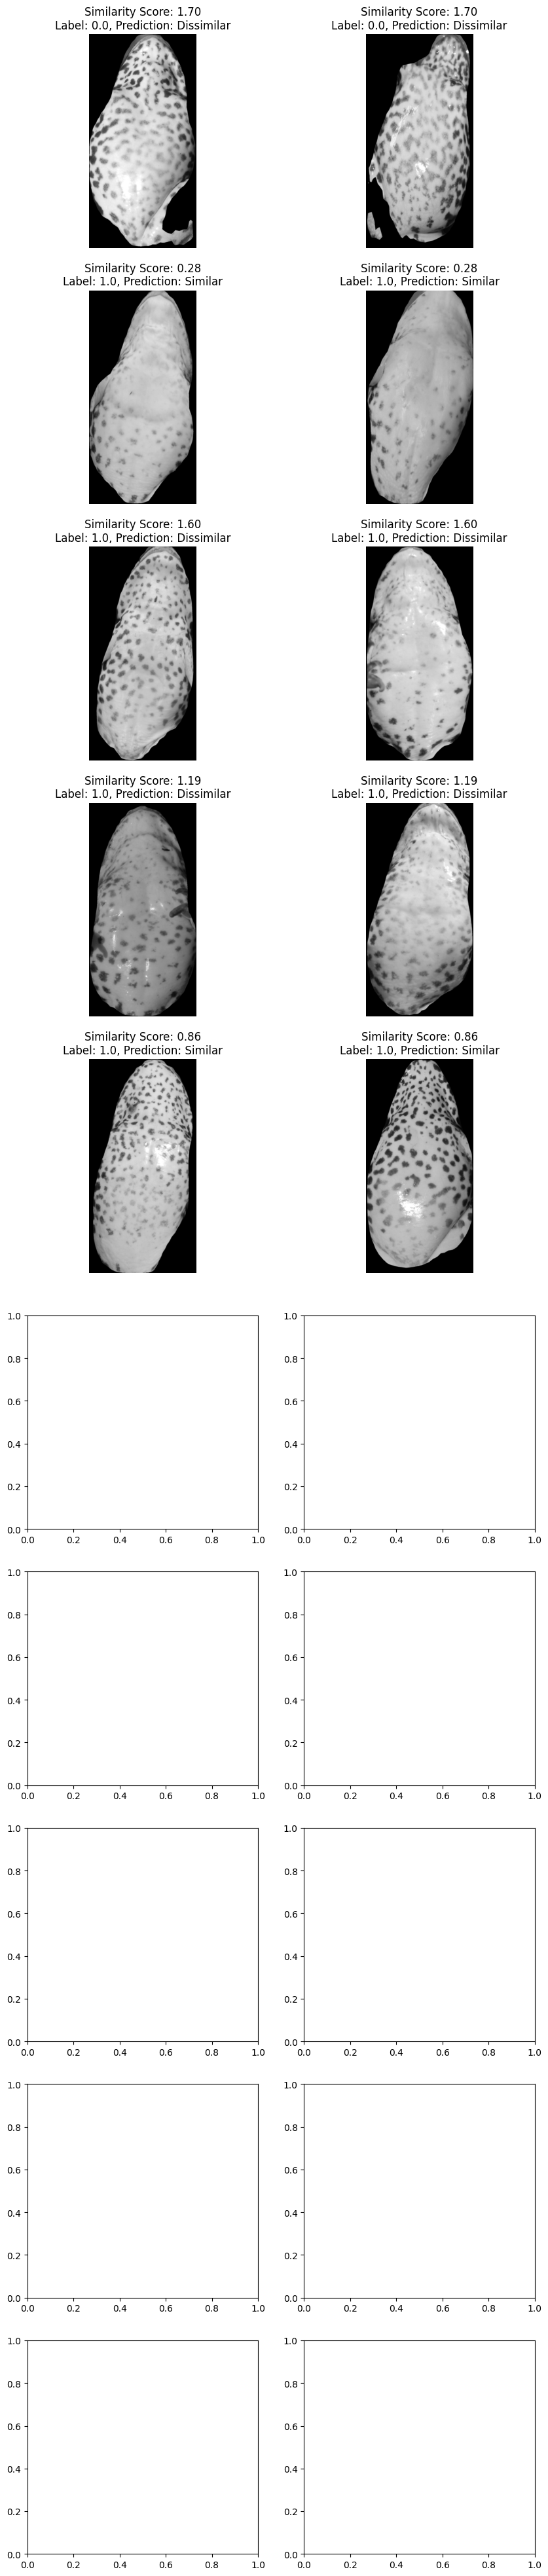

In [36]:
# Visualize predictions on the test set
visualize_predictions(siamese_network, siamese_test_loader, threshold, num_samples=10)

In [ ]:
# Locate the test dataset and load it into the SiameseNetworkDataset
folder_dataset_test = datasets.ImageFolder(root="frog_identification\\alt_data\\Testing")
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transformation)
test_dataloader = DataLoader(siamese_dataset, num_workers=2, batch_size=1, shuffle=True)

In [46]:
dataiter = iter(siamese_test_loader)
(x0, img0_filename, img0_id) = next(dataiter)

for i in range(10):
    # Iterate over 10 images and test them with the first image (x0)
    x1, img1_filename, img1_id = next(dataiter)

    # Concatenate the two images together
    concatenated = torch.cat((x0, x1), 0)

    output1, output2 = siamese_network(x0.cuda(), x1.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')

KeyboardInterrupt: 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

3.508193504930747
